# 3D forward modelling - Hillock example
Simulate a 3D structure with a high resistivity target. Goal is to demonstrate modelling in a 3D environment, although example is not far removed from an archeological target.  

In [2]:
#first step is to load in the relevent resipy api modules 
import sys, os 
sys.path.append('../src')

from resipy import Project
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from scipy.interpolate import LinearNDInterpolator
import time

datadir = '../src/examples/dc-3d/'

API path =  /home/jimmy/phd/resipy/src/resipy
ResIPy version =  3.3.2
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


## Creating 3D topography 
The goal is to simulate a mound on a flat surface, we can acheive this with a kind of cosine function in the x direction and scale it in the y direction (which is the steps taken in the following code block). In this case electrodes are draped on to the topography, 2 perpendicular electrode lines are placed over the hillock. 

/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:66: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  if numpy_array_type == key or \
/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:68: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  numpy_array_type == numpy.dtype(key):
/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you sp

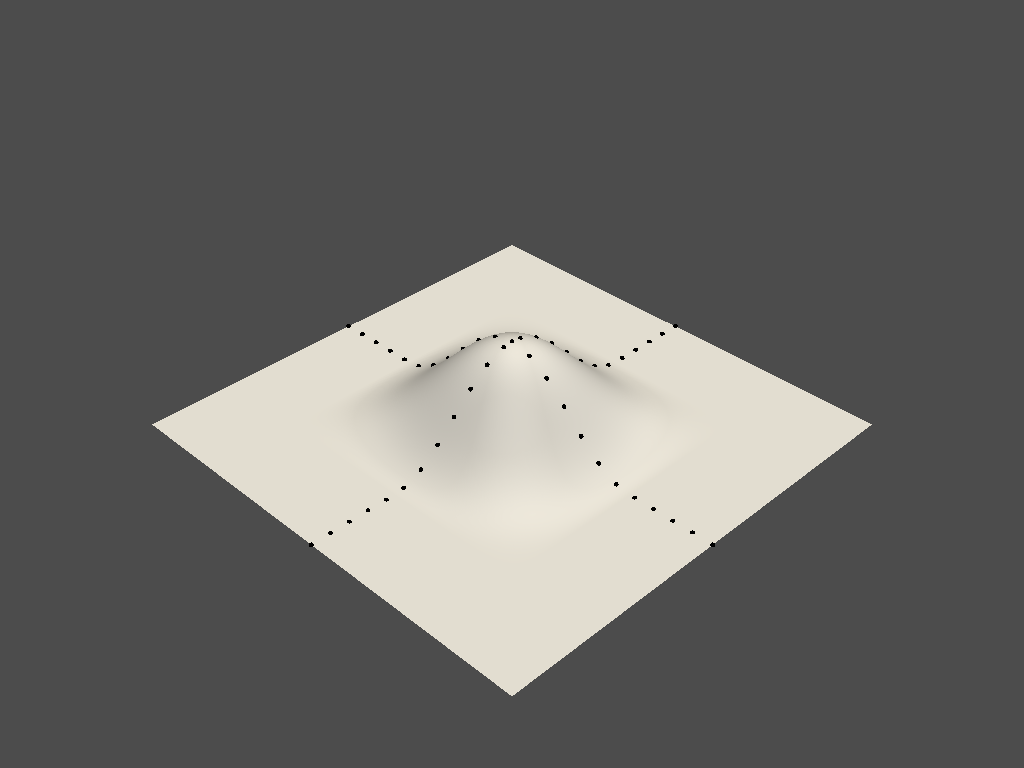

[(195.14442395771323, 195.14442395771323, 173.7282320037936),
 (31.41592653589793, 31.41592653589793, 9.999734581978304),
 (0.0, 0.0, 1.0)]

In [3]:
# create synthetic electrode and topography positions orientated around a hillock (or mound)
# nb: this code block can take a moment to run 

# synthetic x-z coordinates of surface  
x0 = np.linspace(-2,2*np.pi+2,500)
idx = (x0>0) & (x0<2*np.pi)
z0 = np.zeros_like(x0)
z0[idx] = ((np.cos(x0[idx])*-1)+1)*10 # this in effect makes a cosine curve in the x direction that is only positive

#following block extends the topography out from a 2d line 
x = x0*10
y0 = np.zeros_like(x) + np.mean(x)
x1 = np.zeros_like(x) + np.mean(x)
y1 = x.copy()

px = np.append(x,x1)
py = np.append(y0,y1)
pz = np.append(z0,z0)

p = pv.Plotter() # init pyvista object 

#%% go and make surface 
xmesh, ymesh = np.meshgrid(x,y1)
zmesh = np.zeros_like(xmesh)

fac = z0/np.max(z0) # apply a factor to the z coordinate according to the y value 
for i in range(len(x)):
    zi = fac[i]*z0
    zmesh[:,i]=zi
    
points = np.array([xmesh.flatten(),ymesh.flatten(),zmesh.flatten()]).T

# drape electrodes onto the surface. 
num_elec = 24
elecx0 = np.linspace(np.min(x),np.max(x),num_elec)
elecy0 = np.zeros_like(elecx0) + np.mean(y0)

elecy1 = np.linspace(np.min(x),np.max(x),num_elec-1)
elecx1 = np.zeros_like(elecy1) + np.mean(elecx0)

elecx = np.append(elecx0,elecx1)
elecy = np.append(elecy0,elecy1)

pnew = np.array([elecx,elecy]).T
interpolator = LinearNDInterpolator(points[:,0:2],points[:,2])
elecz = interpolator(pnew)

elec = np.array([elecx,elecy,elecz]).T
    
# plot using paraview 
pp = pv.PolyData(points)
surf = pp.delaunay_2d()
pe = pv.PolyData(elec)
p.add_mesh(surf,color='white', point_size=2,show_edges=False)
p.add_mesh(pe,render_points_as_spheres=True,color='k', point_size=5)


## un comment the following to display a traditional 2D plot using paraview 
#fig, ax1 = plt.subplots()
#ax1.scatter(points[:,0],points[:,1],c=points[:,2])
#ax1.scatter(elecx0,elecy0,c='k')
#ax1.scatter(elecx1,elecy1,c='w')
#ax1.set_aspect('equal')

p.show()

# uncomment to save csv files 
# np.savetxt('topo3d.csv',points[::2,:],header='x,y,z',delimiter=',')
# np.savetxt('elec3d.csv',elec,header='x,y,z',delimiter=',')

In [4]:
# next step is to set up a 3D forward modelling project 
k = Project(typ='R3t')
k.setElec(elec) # set the electrodes 

Working directory is: /home/jimmy/phd/resipy/src/resipy
clearing dirname


Creating tetrahedral mesh...done (335287 elements)
335287


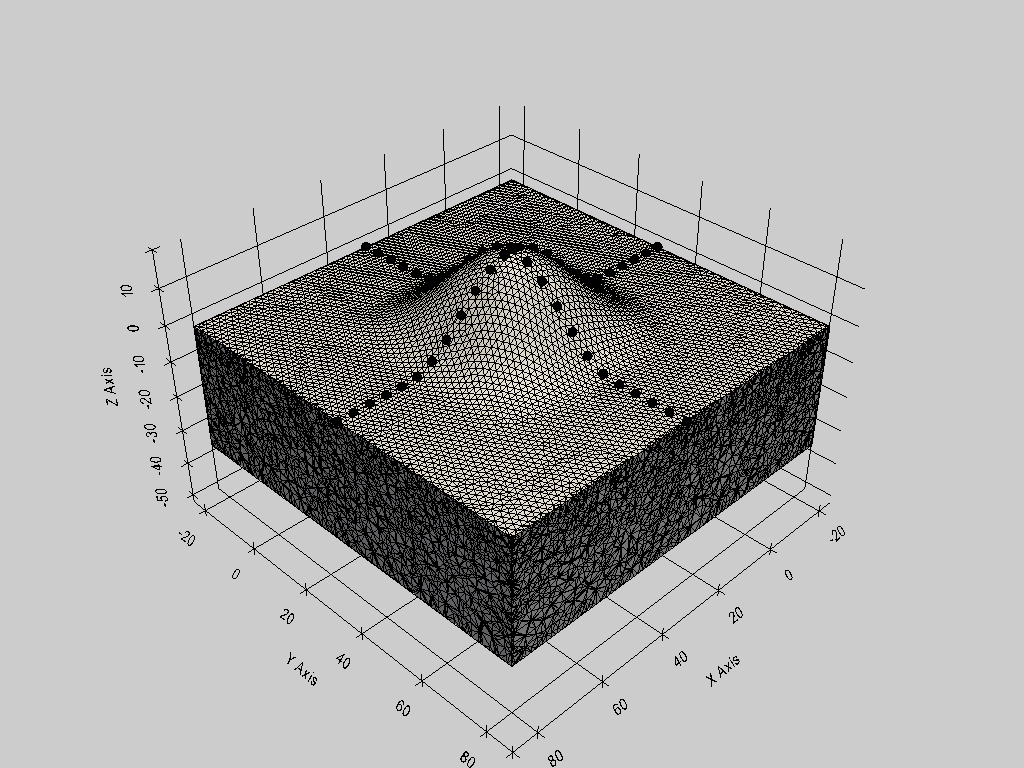

In [5]:
# create a mesh with the topography shown above 
k.createMesh(cl=1.5,surface=points)
print(k.mesh.numel)
k.showMesh()

## Assigning a resistive region 
Here we want to simulate a high resistivity target inside of the mound. This situation isn't far removed from an archeological scenario where one might expect a higher resistivity due to porus and disturbed ground. Note that arguably resistivity would be used to confirm such a target rather than locate it in this case given the topography has already exposed the mounds location. 

Here we use some numpy trickery and features of the mesh processing module within ResIPy to make the centre of the Hillock a high resistivity target. First we compute the depth from the surface to the centriod of each element (or cell) in the 3D tetrahedral mesh. This process involves extracting the upper surface of the mesh (that faces the positive Z direction). We can then isolate mesh elements which are both 1m below the surface and exist above a Z coordinate of 0 (which is only true inside of the mound). 

Reference model successfully assigned


/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,
/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:66: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  if numpy_array_type == key or \
/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:68: DeprecationWarning: Convertin

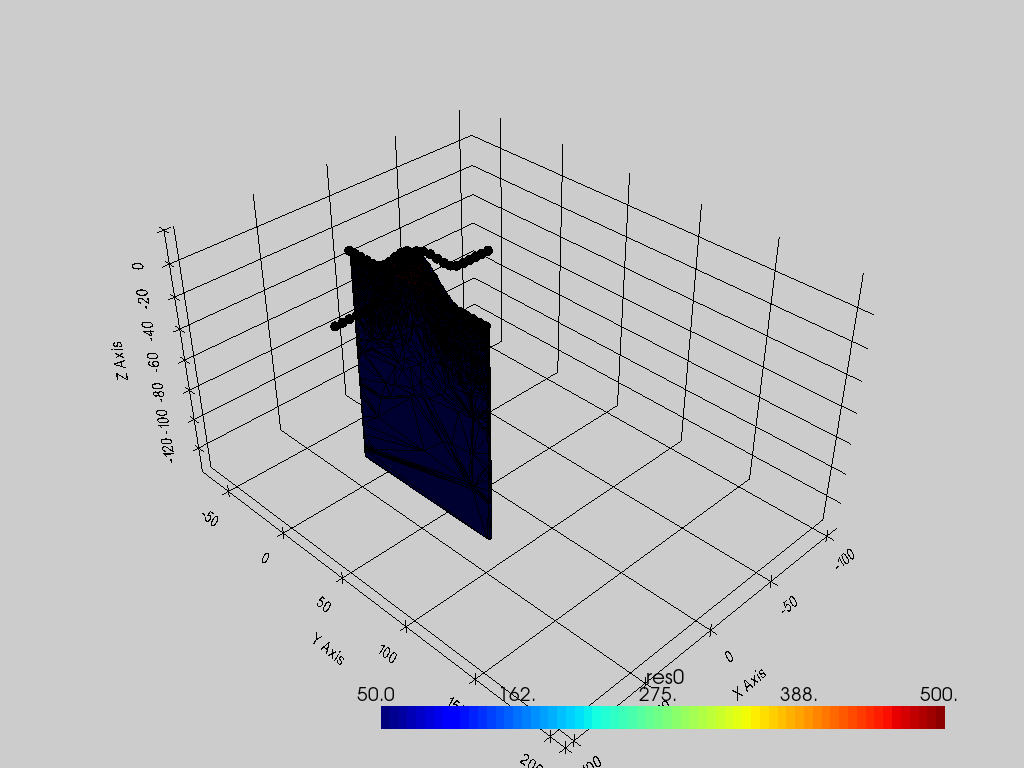

In [6]:
depths = k.mesh.computeElmDepth() # computes the depth below surface to each or element centriod in the mesh.  
Z = k.mesh.df['Z'] # Z coordinates of elements 
idx = (Z>=0) & (depths>1) # isolate mesh elements inside of the mound using numpy indexing 
res0 = np.zeros_like(Z)+50 # makes a column of resistivity values attributed to each element 
res0[idx] = 500 # overwrites resistivity value inside of mound elements (now equal 500)

# k.mesh.df.loc[idx,'res0']=500
k.setRefModel(res0) # set the reference model to the resistivty array we just created 
k.mesh.show3D(xlim=[29,31],attr='res0',color_map='jet')
k.mesh.paraview()

## Create a forward modelling scheduling routine 
Now that we have created 3D electrode positions, we can make a call to ResIPy to create a forward modelling sequence. Nowhere in this script have we actually told ResIPy what the electrode lines are, so far it only sees a discrete set of 3D points, however this is okay for our purposes as ResIPy has capacity to guess electrode lines given XY coordinates for surface investigations. These electrode lines (or strings) will be assigned automatically when making a call to create a forward modelling schedule. Also note that the same options for array configurations present within 2D forward modelling are present here also (e.g. Wenner and Dipole - Dipole). 

Once completing this step we have created everything needed to run a forward model (electrode positions, mesh, starting resistivities and schedule). 

In [7]:
k.createSequence([('dpdp1',1,8),('dpdp1',2,8)]) # create a schedule with dipole dipole array configurations 
k.forward(noise=2) # run the forward model with 2% noise 

456 quadrupoles generated.
Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

 >> R 3 t     E R T    M o d e l    v 2.31 <<

 >> Date: 21-10-2021
 >> My beautiful 3D survey                                                          
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> A d v a n c e d   M e s h   I n p u t <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from resistivity.dat                                                                 

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.044 Gb
    For   2000 measurements the memory needed is:          0.044 Gb
    For   5000 measurements the memory needed is:          0.044 Gb
    For  10000 measurements the memory needed is:          0.045 Gb


## Inverting the data 
When creating a forward model ResIPy classes this as a new survey and is treated just like any other data imported into the API. Henceforth all inversion options avialable to inverting 'standard' data can be replicated here. Where there is a minor difference is collecting results, as the first "Result" stored inside of ResIPy is the setup of the forward model, this is so the user can compare the results of the inverse modelling to that of the initial model. In this case we will stay with default inversion options, get the results and display them. 

In [8]:
res0 = np.zeros_like(Z)+100 # we need to reset the starting resistivities for the inversion.
k.setRefModel(res0)
k.invert() # invert the forward model (make take some time)

Reference model successfully assigned
Writing .in file and protocol.dat... All non fixed parameters reset to 100 Ohm.m and 0 mrad, as the survey to be inverted is from a forward model.
done

--------------------- MAIN INVERSION ------------------


 >> R 3 t     E R T    M o d e l    v 2.31 <<

 >> Date: 21-10-2021
 >> My beautiful 3D survey                                                          
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> A d v a n c e d   M e s h   I n p u t <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from Start_res.dat                                                                   

 >> L o g - D a t a   I n v e r s i o n <<
 >> B a c k g r o u n d   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory need

/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,
/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:66: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  if numpy_array_type == key or \
/home/jimmy/miniconda3/envs/pyvista/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:68: DeprecationWarning: Convertin

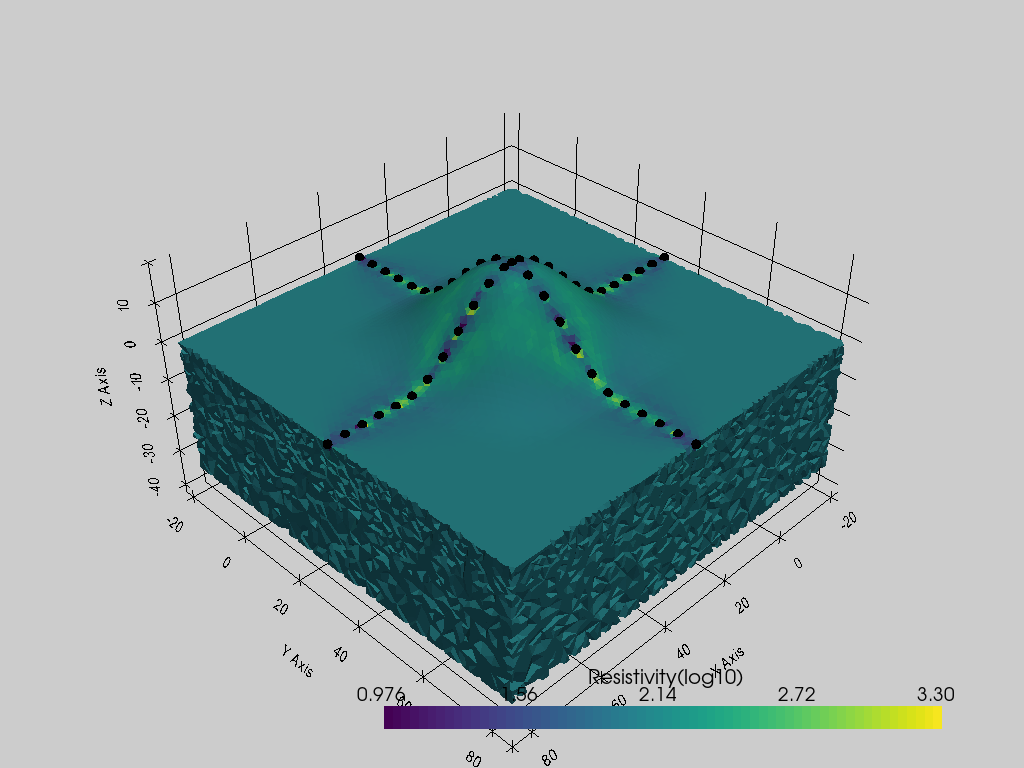

In [9]:
k.showResults(1) #display model indexed at 1 (remember python indexing starts at 0)


In [10]:
#nb there is a problem with the version of pyvista used in this example 